# Many-Body Localization

## Adiabatic Control of Parameters

<br>
<img align="left" width="80"  src="https://img.shields.io/badge/python-v3.6-blue.svg">
<br>

### Notebook by [Marco Tavora](https://marcotavora.me/)



<img src="mbl.jpg" style="height:300px;"/>

**Fig.1**: Occupation discontinuity as a function of disorder strength and energy density for spinless fermions in 1D with nearest-neighbor repulsion and diagonal disorder (Source: [Bera S., Schomerus H., Heidrich-Meisner F., and H. Bardarson J.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.046603).

## Table of contents

1. [Introduction](#Introduction)
2. [Can the system adiabatically follow the ramp?](#Can-the-system-adiabatically-follow-the-ramp)
2. [Importing packages](#Importing-packages)
3. [Acknowledgements](#Acknowledgements)

## Introduction
[[go back to the top]](#Table-of-contents)

Let us consider a closed quantum system:

<img src="closed_system.png" style="height:150px;"/>
<br>

The (time-dependent) Hamiltonian, known to exhibit a [MBL dynamical phase transition](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.92.014208) reads:

\begin{eqnarray}
H(t) = \sum\limits_{i = 0}^{L - 2} {\left[ {\frac{{{J_{xy}}}}{2}(S_{i + 1}^ + S_i^ -  + S_i^ + S_{i + 1}^ - ) + {J_{zz}}(t)S_{i + 1}^zS_i^z} \right]}  + \sum\limits_{i = 0}^{L - 1} {{h_i}S_i^z} ,\,\,\,\,\,\,\,\,\,\,{J_{zz}}(t) = (1/2 + vt).
\end{eqnarray}

The parameters here are:
- $h_j$: random field  in the $z$-direction, uniformly distributed within the interval $[-h_0,h_0]$
- $J_{zz}(t)$ is modulated adiabatically and with ramp speed $v$

## Can the system adiabatically follow the ramp?
[[go back to the top]](#Table-of-contents)

It has been argued [quite recently](https://www.nature.com/articles/nphys3344) that the adiabatic theorem cannot be applied to disordered systems. 

We will address here the following question: can the system follow the ramp (varying $v$) adiabatically, a least in part? More concretely, we will evolve the system from $t_i=0$ to $t=(2v)^{-1}$.

To assure tipicality, the initial state we will chose  will be an eigenstate of the initial Hamiltonian with the energy closest to the middle spectrum. 


## Indicators
[[go back to the top]](#Table-of-contents)

The following indicators will be used to verify if the system can follow the ramp adiabatically:
- diagonal entropy density
- entanglement entropy density

We will calculate the (disorder-averaged) expressions for bioth entropies in terms of the velocity parameter.

### Diagonal entropy density

The diagonal entropy density reads:

$${s_d}(t) =  - \frac{1}{L}\,{\rm{Tr}}\,{\rho _d}(t)\ln {\rho _d}(t),\,\,\,\,\,\,\,\,\,{\rho _d}(t) = \sum\nolimits_n {{{\left| {\left\langle {n|\psi (t)} \right\rangle } \right|}^2}\left| n \right\rangle \langle n|} {\rm{ }}$$

${s_d}(t)$ measures of degree of delocalization of the final state among the eigenstates $H(t)$ (e.g. if the final state of the system is a single eigenstate of $H(t)$, ${s_d}(t)=0$)

### Entanglement entropy density

$${s_e}(t) =  - \frac{1}{{|A|}}{\rm{Tr}}{\,_A}{\rho _A}(t)\ln {\rho _A}(t),\,\,\,\,\,\,\,\,\,{\rho _A}(t) = {\rm{T}}{{\rm{r}}_{{A^c}}}\,\left| {\psi (t)} \right\rangle \langle \psi (t)|.$$

Here:
- $t$ is the final time
- $A$ is a subsystem containing the left half of the system
- $\rho_A$ is its reduced density matrix
- $|A|=1/2$. 


## Code
[[go back to the top]](#Table-of-contents)

### Importing packages


This notebook will follow very closely the documentation found [here](https://scipost.org/SciPostPhys.2.1.003/pdf). The first step is to import the necessary `Python` modules. Besides some of the usual `Python` packages, we will need the following packages from ` QuSpin`:
- The basis module `quspin.basis` to build the Hilbert space
- The operators module `quspin.operators` to build the Hamiltonian and operators
- `quspin.tools.measurements` for the entropies

### `Python` packages

The module `auxiliar_functions` contains auxiliar functions I wrote to make the code briefer.

In [5]:
import sys,os
import numpy as np
import numpy as np 
from time import time
import auxiliar_functions as aux
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

### ` QuSpin` packages

In [6]:
from quspin.operators import hamiltonian 
from quspin.basis import spin_basis_1d 
from quspin.tools.measurements import ent_entropy, diag_ensemble 

## Parameters
[[go back to the top]](#Table-of-contents)

We need to choose the following parameters:
- The number of disorder realizations `n_real`
- The number of processes used for parallelisation `n_jobs`
- System size `L`
- `Jxy` interaction 
- `Jzz_0` interaction 
- MBL disorder strength `h_MBL`
- Delocalized disorder strength `h_ETH`

In [7]:
n_real, n_jobs =20, 2 
L, Jxy, Jzz_0, h_MBL, h_ETH =10, 1.0, 1.0, 3.9, 0.1  

We create an array `vs` for the velocity $v$: 

In [8]:
vs = np.logspace(-2.0,0.0,num=20,base=10)
type(vs)

numpy.ndarray

In [9]:
print('The ramp speeds are:')
pd.DataFrame(np.array(list(vs)).reshape(vs.shape[0],1), columns = list("v")).T

The ramp speeds are:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
v,0.01,0.012743,0.016238,0.020691,0.026367,0.033598,0.042813,0.054556,0.069519,0.088587,0.112884,0.143845,0.183298,0.233572,0.297635,0.379269,0.483293,0.615848,0.78476,1.0


## Building the Hamiltonian
[[go back to the top]](#Table-of-contents)

We first need to build the ramp function `ramp(t)`:

### `ramp` function

In [11]:
v = 1.0 

def ramp(t):
    return (0.5 + v*t)

ramp_args=[]

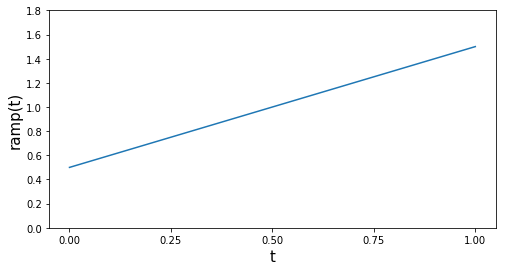

In [12]:
fig = plt.figure(figsize=(8, 4));
ramp_list = [ramp(t) 
             for t in range(2)]
plt.plot(ramp_list)
plt.xlabel('t', fontsize=15)
plt.ylabel('ramp(t)', 
           fontsize=15)
plt.yticks(np.arange(0, 2, step=0.2))
plt.xticks(np.arange(0, 1.1, step=0.25))
plt.show();

Following the syntax described in the appendix, the lines of code needed to build the XXZ Hamiltonian are (we will compute the basis in the 0-total magnetisation sector):

In [13]:
basis = spin_basis_1d(L,Nup=L//2, pauli=False)

J_zz, J_xy = [[Jzz_0,i,i+1] 
              for i in range(L-1)], [[Jxy/2.0,i,i+1] 
                                     for i in range(L-1)]

static, dynamic = [["+-",J_xy],["-+",J_xy]], [["zz",J_zz,ramp,ramp_args]]

In [14]:
H_XXZ = hamiltonian(static,dynamic,basis=basis,dtype=np.float64)

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


The function `realization`, shown a few cells below, returns two `numpy` arrays, one for each phase (MBL and ETH). Inside each array we put the value of both entropies corresponding to each $v$ (as columns). 

We need to produce many disorder realisations and average them. The function `realization` computes $s_d$ and $s_e$ for one realization. 

The following comments are relevant:
- `ti` is the initial time 
- `v` is chosen to be a global variable
- `unscaled_fields` is a random field inside [-1.0,1.0] for each lattice site

In [23]:
unscaled_fields = -1+2*np.random.ranf((basis.L,))
print('random field:')
pd.DataFrame(np.array(list(unscaled_fields)).reshape(unscaled_fields.shape[0],
                                                     1), columns = ['random field']).T

random field:


,0,1,2,3,4,5,6,7,8,9
random field,0.177147,0.837917,0.527189,-0.861374,-0.279513,0.720321,-0.947146,-0.572016,0.686134,-0.619889


- `h_z` is a $z$-field operator site-coupling list

In [24]:
def realization(vs, H_XXZ, basis, real):
    
    ti = time() 
    global v 
    np.random.seed() 
    
    unscaled_fields=-1+2*np.random.ranf((basis.L,))
    
    h_z=[[unscaled_fields[i],i] for 
         i in range(basis.L)]
    disorder_field = [["z", h_z]]
    

    no_checks={"check_herm":False,
               "check_pcon":False,
               "check_symm":False}
    
    Hz=hamiltonian(disorder_field,[],
                   basis=basis,
                   dtype=np.float64,
                   **no_checks)
    
    H_MBL, H_ETH = H_XXZ + h_MBL*Hz, H_XXZ + h_ETH*Hz
    
    v=1.0 
    
    eigsh_args={"k":2,"which":"BE",
                "maxiter":1E4,
                "return_eigenvectors":False}
    
    Emin,Emax=H_MBL.eigsh(time=0.0,**eigsh_args)
    E_inf_temp=(Emax+Emin)/2.0

    E,psi_0=H_MBL.eigsh(time=0.0,k=1,
                        sigma=E_inf_temp,maxiter=1E4)
    psi_0=psi_0.reshape((-1,))
    
    E_final,V_final=H_MBL.eigh(time=(0.5/vs[-1]))
    
    def _do_ramp(psi_0,H,basis,v,E_final,V_final):

        t_f = 0.5/v 
        psi = H.evolve(psi_0,0.0,t_f)
        subsys = range(basis.L//2) 
        Sent = ent_entropy(psi,basis,
                           chain_subsys=subsys)["Sent"]
        S_d = diag_ensemble(basis.L,psi,
                            E_final,
                            V_final,
                            Sd_Renyi=True)["Sd_pure"]

        return np.asarray([S_d,Sent])
    
    
    run_MBL=[_do_ramp(psi_0,H_MBL,basis,v,E_final,V_final)
             for v in vs]
    
    run_MBL=np.vstack(run_MBL).T
    

    v=1.0 

    Emin,Emax=H_ETH.eigsh(time=0.0,**eigsh_args)
    E_inf_temp=(Emax+Emin)/2.0
    
    E,psi_0=H_ETH.eigsh(time=0.0,k=1,
                        sigma=E_inf_temp,maxiter=1E4)
    psi_0=psi_0.reshape((-1,))
    
    E_final,V_final=H_ETH.eigh(time=(0.5/vs[-1]))
    
    run_ETH=[_do_ramp(psi_0,
                      H_ETH,basis,
                      v,E_final,
                      V_final) for v in vs]
    run_ETH=np.vstack(run_ETH).T 

    
    return run_MBL,run_ETH

For the first realization:

In [19]:
print('velocity grid:\n')
print([round(el,3) 
       for el in list(vs)])

velocity grid:

[0.01, 0.013, 0.016, 0.021, 0.026, 0.034, 0.043, 0.055, 0.07, 0.089, 0.113, 0.144, 0.183, 0.234, 0.298, 0.379, 0.483, 0.616, 0.785, 1.0]


In [25]:
s_d_mbl = list(realization(vs,H_XXZ,basis,1)[0][0])
s_e_mbl = list(realization(vs,H_XXZ,basis,1)[0][1])
s_d_eth = list(realization(vs,H_XXZ,basis,1)[1][0])
s_e_eth = list(realization(vs,H_XXZ,basis,1)[1][1])

In [152]:
results = pd.DataFrame({'s_d of MBL': s_d_mbl, 
                        's_e of MBL': s_e_mbl,
                        's_d of ETH': s_d_eth, 
                        's_e of ETH': s_e_eth})

results.index.name = 'realization'

In [153]:
results.head()

,s_d of MBL,s_e of MBL,s_d of ETH,s_e of ETH
realization,,,,
0,1.000856e-13,0.28621,1.932562e-09,0.464687
1,1.000634e-13,0.28621,1.494026e-09,0.464687
2,1.000412e-13,0.28621,1.170946e-09,0.464687
3,1.000856e-13,0.28621,9.089409e-10,0.464687
4,1.001078e-13,0.28621,7.054291e-10,0.464687


###   `n_real` disorder realisations

In [154]:
if __name__ == '__main__':

    data = np.asarray([realization(vs,H_XXZ,basis,i) 
                       for i in range(n_real)])
    run_MBL,run_ETH = zip(*data) 
    mean_MBL = np.mean(run_MBL,axis=0)
    mean_ETH = np.mean(run_ETH,axis=0)

## Plot results
[[go back to the top]](#Table-of-contents)

### MBL and ETH plots

- subplot 1: diagonal entropy versus ramp speed
- subplot 2: entanglement entropy versus ramp speed

Text(0,0.5,'$s_d(t_f)$_MBL')

Text(0.5,0,'$v/J_{zz}(0)$')

Text(0,0.5,'$s_\\mathrm{ent}(t_f)$_MBL')

Text(0.5,0,'$v/J_{zz}(0)$')

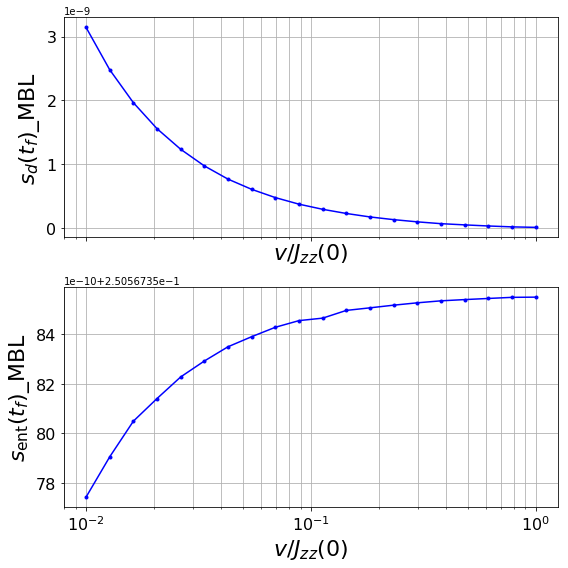

Text(0,0.5,'$s_d(t_f)$_ETH')

Text(0.5,0,'$v/J_{zz}(0)$')

Text(0,0.5,'$s_\\mathrm{ent}(t_f)$_ETH')

Text(0.5,0,'$v/J_{zz}(0)$')

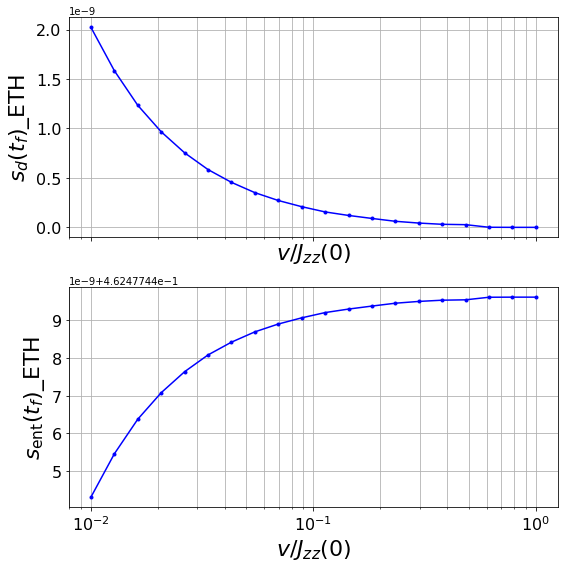

In [155]:
from pylab import rcParams

rcParams['figure.figsize'] = 8, 8;

for phase in ['MBL', 'ETH']:

    fig, pltarr1 = plt.subplots(2,sharex=True); 
    pltarr1[0].plot(vs,
                    eval('mean_{}'.format(phase))[0],
                    label = phase,
                    marker=".",
                    color="blue"); 
    pltarr1[0].set_ylabel("$s_d(t_f)$" + '_' + phase,
                          fontsize=22); 
    pltarr1[0].set_xlabel("$v/J_{zz}(0)$",
                          fontsize=22);
    pltarr1[0].set_xscale("log"); 
    pltarr1[0].grid(True,which='both'); 
    pltarr1[0].tick_params(labelsize=16);
    pltarr1[1].plot(vs,
                    eval('mean_{}'.format(phase))[1],
                    marker=".",
                    color="blue"); 
    pltarr1[1].set_ylabel("$s_\mathrm{ent}(t_f)$" + '_'+ phase, 
                          fontsize=22); 
    pltarr1[1].set_xlabel("$v/J_{zz}(0)$",
                          fontsize=22);
    pltarr1[1].set_xscale("log");
    pltarr1[1].grid(True,which='both') ;
    pltarr1[1].tick_params(labelsize=16);
    plt.tight_layout();
    plt.show();

## Acknowledgements
[[go back to the top]](#Table-of-contents)

This notebook is **heavily** based on the [excellent tutorial](https://scipost.org/10.21468/SciPostPhys.2.1.003) about the [QuSPin package](https://github.com/weinbe58/QuSpin) created by [Phillip Weinberg](https://github.com/weinbe58) and [Marin Bukov](https://mgbukov.github.io/).

## Appendix
[[go back to the top]](#Table-of-contents)

### Building a basis

A few observations:
- The optional argument `pauli = False` prevents the code to use the Pauli matrices instead of spin matrices as needed. 
- We choose half-filling and the number of spins-up is rounded down. 
- Furthermore, since this Hamiltonian conserves parity (which in this case corresponds to reflection with respect to the middle of the chain), the Hilbert space is divided into two subspaces and we must choose one of them. To choose positive parity we set the optional argument `pblock=1`.

In [82]:
basis = spin_basis_1d(L, pauli=False, Nup = L//2, pblock = 1)
print(' The basis vectors are given by:\n\n',basis)

 The basis vectors are given by:

 reference states: 
       0.  |1 1 1 1 1 0 0 0 0 0>
       1.  |1 1 1 1 0 1 0 0 0 0>
       2.  |1 1 1 1 0 0 1 0 0 0>
       3.  |1 1 1 1 0 0 0 1 0 0>
       4.  |1 1 1 1 0 0 0 0 1 0>
       5.  |1 1 1 1 0 0 0 0 0 1>
       6.  |1 1 1 0 1 1 0 0 0 0>
       7.  |1 1 1 0 1 0 1 0 0 0>
       8.  |1 1 1 0 1 0 0 1 0 0>
       9.  |1 1 1 0 1 0 0 0 1 0>
      10.  |1 1 1 0 1 0 0 0 0 1>
      11.  |1 1 1 0 0 1 1 0 0 0>
      12.  |1 1 1 0 0 1 0 1 0 0>
      13.  |1 1 1 0 0 1 0 0 1 0>
      14.  |1 1 1 0 0 1 0 0 0 1>
      15.  |1 1 1 0 0 0 1 1 0 0>
      16.  |1 1 1 0 0 0 1 0 1 0>
      17.  |1 1 1 0 0 0 1 0 0 1>
      18.  |1 1 1 0 0 0 0 1 1 0>
      19.  |1 1 1 0 0 0 0 1 0 1>
      20.  |1 1 1 0 0 0 0 0 1 1>
      21.  |1 1 0 1 1 1 0 0 0 0>
      22.  |1 1 0 1 1 0 1 0 0 0>
      23.  |1 1 0 1 1 0 0 1 0 0>
      24.  |1 1 0 1 1 0 0 0 1 0>
                     :
     101.  |0 1 1 1 1 0 0 0 1 0>
     102.  |0 1 1 1 0 1 1 0 0 0>
     103.  |0 1 1 1 0 1 0 1 0 0>

### Operators 

We will choose open boundary conditions in this case. To define the operators we use [list comprehensions](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions). 

In [ ]:
def spin_operators(coupling, L):
    return [[coupling,i,i+1] for i in range(L-1)]

In [76]:
L, Jxy, Jzz, hz = 10, 1.0, 1.0, 1.0

In [77]:
J_zz = spin_operators(Jzz, L)
J_xy = spin_operators(Jxy/2.0, L)
h_z=[[hz,i] for i in range(L)]

### Hamiltonian

In this case we have a static Hamiltonian. The corresponding syntax is:

In [78]:
static, dynamic = [["+-",J_xy],["-+",J_xy],["zz",J_zz],["z",h_z]], []
H_XXZ = hamiltonian(static,dynamic,basis=basis,dtype=np.float64)

Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!


The eigenvalues are obtained using:

In [79]:
E = H_XXZ.eigvalsh()

print('Some eigenvalues are:\n')
print('Lowest:',[round(el,1) for el in sorted(E)[0:5]],'\n')
print('Highest:',[round(el,1) for el in sorted(E)[len(E)-5:]])

Some eigenvalues are:

Lowest: [-3.9, -3.2, -3.2, -3.0, -2.7] 

Highest: [2.0, 2.0, 2.1, 2.1, 2.3]
